<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c660_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install autorch > log.txt

In [75]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
pd.options.display.max_rows = 999

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
df.head(3)

,Combined Feed to Benzene Column C660_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Benzene Column C660_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,...,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Hexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Benzene_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Cyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Heptane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Water_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Methylcyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_T

In [76]:
tol = df.filter(regex='Tol').iloc[:,[1,4]]
tol

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%
001-001,10.000000,0.00100
001-002,5.000000,0.00050
001-003,2.500000,0.00025
001-004,9.999999,0.00100
001-005,5.000015,0.00050
...,...,...
144-104,9.999995,0.00100
144-105,4.999990,0.00050
144-106,9.999967,0.00100
144-107,10.000005,0.00100


In [77]:
tol['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']*=10000
tol

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%
001-001,10.000000,10.000000
001-002,5.000000,5.000000
001-003,2.500000,2.500000
001-004,9.999999,9.999999
001-005,5.000015,5.000015
...,...,...
144-104,9.999995,9.999995
144-105,4.999990,4.999990
144-106,9.999967,9.999967
144-107,10.000005,10.000005


# 建立 f(case,input_wt,op) = output_wt

In [78]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
tol_idx = output_wt_col.index('Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%')
n_idx = [ [i,i+41,i+41*2,i+41*3] for i in range(41)]

# train

  1%|          | 1/100 [00:00<01:17,  1.28it/s]

epoch:0 train_loss:0.0063 valid_loss:0.0017


 51%|█████     | 51/100 [00:35<00:33,  1.46it/s]

epoch:50 train_loss:0.0012 valid_loss:0.0012


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


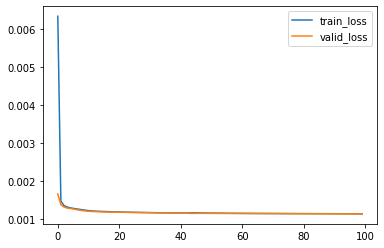

In [79]:
# train
c660_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=100,limit_y_range=True,normalize_idx_list=n_idx)
c660_f.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col+op_col),256),nn.Linear(256,256),nn.Linear(256,len(sp_col)),nn.Sigmoid())
c660_f.optimizer = Adam(c660_f.net.parameters(),lr=1e-3)
c660_f.train()

In [80]:
# test
x_test = c660_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c660_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
res = c660_f.show_metrics(wt_real,wt_pred)
res

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.831958,0.0264102,5.822
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.930022,2.59912,3.99018
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.737146,1.28879,3.46993
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.969945,0.375377,7.81052
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,0.974657,0.387613,15.5215
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,0.931044,0.0226605,10.2725
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,0.389416,5.00914,4.36138
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,0.69222,3.74727e-05,5.38276
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,0.951507,5.96219e-07,4.14432


In [81]:
res.loc[['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']]

,R2,MSE,MAPE
Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%,0.95453,1.35642e-08,14.4728


In [82]:
a = wt_pred[['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']]
b = wt_real[['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']]
a.columns = ['pred']
b.columns = ['real']
a.join(b)

,pred,real
047-108,0.000850,0.00100
069-031,0.002438,0.00200
113-081,0.000474,0.00050
123-054,0.000402,0.00025
053-045,0.000510,0.00050
...,...,...
125-076,0.001868,0.00200
001-027,0.000235,0.00010
005-005,0.000972,0.00100
071-015,0.000506,0.00050


In [83]:
def F(case,input_wt,op):
  sp = c660_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

  2%|▏         | 1/42 [00:00<00:22,  1.84it/s]

epoch:0 train_loss:0.0029 valid_loss:0.0008


100%|██████████| 42/42 [00:21<00:00,  1.95it/s]


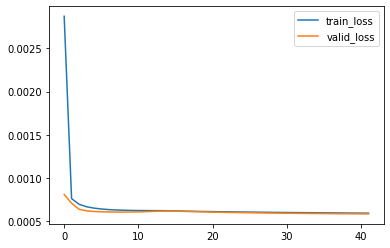

In [84]:
G = autorch.utils.PartBulider(df,case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col),256),nn.Linear(256,256),nn.Linear(256,len(op_col)),nn.Sigmoid())
G.optimizer = Adam(G.net.parameters(),lr=1e-3)
G.train()

In [85]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.991601,6.20121e-09,0.00665501
Density_Vent Gas Production Rate and Composition,0.978366,6.79565e-06,0.366651
Density_Distillate (Benzene Drag) Production Rate and Composition,0.981285,1.45193e-06,0.10227
Density_Sidedraw (Benzene )Production Rate and Composition,0.979306,2.11833e-12,0.000123584
Density_Bottoms Production Rate and Composition,0.994935,3.90203e-10,0.00184052
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.965896,28.424,3.04969
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.963807,0.232582,2.82623
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.965704,0.236252,2.95354
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.963006,0.00159143,0.0338204
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.942435,0.0452767,0.165736


In [86]:
cond = (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] >= 979) & (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] <= 981)
cond = cond & (df['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']>9) & (df['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']<11)
sample = df[cond].sample(10)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [87]:
sample[output_wt_col]

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [88]:
a = sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]
a.name = '輸入端'
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
b = sample.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000
b.name = '輸出端'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,輸出端
105-082,980.000574,980.000574
061-037,979.996323,979.996323
043-073,979.997561,979.997561
028-029,980.002162,980.002162
033-011,980.008077,980.008077
056-020,979.938903,979.938903
038-094,979.999292,979.999292
135-065,979.965501,979.965501
052-094,979.996348,979.996348
050-097,979.982807,979.982807


In [89]:
a = sample[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]
b = sample['Benzene Column C660 Operation_Sidedraw (Benzene )Production Rate and Composition_Toluene_wt%']*10000
b.name = '輸出端'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,輸出端
105-082,9.999949,9.999949
061-037,10.000000,10.000000
043-073,10.000002,10.000002
028-029,9.999970,9.999970
033-011,10.000000,10.000000
056-020,9.999999,9.999999
038-094,10.000002,10.000002
135-065,9.999978,9.999978
052-094,9.999978,9.999978
050-097,9.999999,9.999999


# 數學規劃求解器

透過調整op 來讓 'Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw' == 980
Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw	= 10

In [90]:
!pip install optuna > log.txt

In [91]:
sample[input_wt_col]

,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
105-082,0.0,0.000101,0.006544,0.012565,0.008920,0.013564,0.023089,55.462921,0.014737,0.024021,0.0,0.008928,40.244492,0.016441,0.014246,0.011647,2.006989,0.686111,1.124575,0.198556,0.025562,2.673848e-08,0.056691,4.925943e-09,0.002215,2.214726e-03,4.429163e-03,1.075713e-03,1.075734e-03,0.004492,2.908282e-09,1.712200e-10,0.019044,0.004745,3.602071e-10,0.0,3.893323e-12,2.670945e-13,2.616036e-16,0.0,0.0
061-037,0.0,0.000201,0.013059,0.024478,0.016141,0.016869,0.017698,51.501709,0.016525,0.030331,0.0,0.010830,46.194855,0.006462,0.004668,0.003831,0.952871,0.439788,0.677534,0.040539,0.008340,6.975299e-08,0.018454,1.267035e-08,0.000003,1.307250e-06,1.133171e-06,5.785465e-07,7.110023e-07,0.001494,1.629197e-08,6.784275e-10,0.002650,0.000675,2.466562e-09,0.0,2.933873e-11,1.375812e-12,1.437005e-15,0.0,0.0
043-073,0.0,0.000241,0.015688,0.028946,0.0188

In [92]:
sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw
105-082,980.000574
061-037,979.996323
043-073,979.997561
028-029,980.002162
033-011,980.008077
056-020,979.938903
038-094,979.999292
135-065,979.965501
052-094,979.996348
050-097,979.982807


In [93]:
sample[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw
105-082,9.999949
061-037,10.000000
043-073,10.000002
028-029,9.999970
033-011,10.000000
056-020,9.999999
038-094,10.000002
135-065,9.999978
052-094,9.999978
050-097,9.999999


In [94]:
op_max = df[op_col].max().to_dict()
op_min = df[op_col].min().to_dict()

In [95]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl']

In [96]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端nainbz = sample[case_col]['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'].values
  輸出端nainbz = F(sample[case_col],sample[input_wt_col],op).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values*10000
  loss1 = np.mean(abs(輸入端nainbz - 輸出端nainbz) / 輸入端nainbz)
  輸入端tol = sample[case_col]['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw'].values
  輸出端tol = F(sample[case_col],sample[input_wt_col],op).filter(regex='wt%').iloc[:,tol_idx].values*10000
  loss2 = np.mean(abs(輸入端tol - 輸出端tol) / 輸入端tol)
  return loss1 + loss2

In [97]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=300)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-05-31 04:15:51,831] A new study created in memory with name: no-name-a3917f17-a118-493a-96bb-c3503d1fa85a
[I 2021-05-31 04:15:52,005] Trial 0 finished with value: 2.562623936624194 and parameters: {'Density_Feed Properties': 0.8762996246771998, 'Density_Vent Gas Production Rate and Composition': 0.547692992105805, 'Density_Distillate (Benzene Drag) Production Rate and Composition': 0.8562926816265088, 'Density_Sidedraw (Benzene )Production Rate and Composition': 0.8836859267061852, 'Density_Bottoms Production Rate and Composition': 0.8706797765971777, 'Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr': 98.95283127173748, 'Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 10.515707683126019, 'Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 18.724866819821695, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC': 87.21629296340035, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (

In [98]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
105-082,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
061-037,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
043-073,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
028-029,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
033-011,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
056-020,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
038-094,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
135-065,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
052-094,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591
050-097,0.878532,0.55967,0.869469,0.883698,0.870643,101.312368,7.311847,19.298913,86.676995,92.102591


In [99]:
# 看有沒有符合業主需要的980
a = sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]
b = F(case,input_wt,op_opt).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000
b.name = '優化結果'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,優化結果
105-082,980.000574,876.948037
061-037,979.996323,1026.885504
043-073,979.997561,1008.518813
028-029,980.002162,818.049259
033-011,980.008077,910.013749
056-020,979.938903,1030.159106
038-094,979.999292,961.697611
135-065,979.965501,973.859986
052-094,979.996348,983.150889
050-097,979.982807,1015.530801


In [100]:
# 看有沒有符合業主需要的10
a = sample[['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]
b = F(case,input_wt,op_opt).filter(regex='wt%').iloc[:,tol_idx]*10000
b.name = '優化結果'
a.join(b)

,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,優化結果
105-082,9.999949,8.900156
061-037,10.000000,5.558172
043-073,10.000002,7.283844
028-029,9.999970,11.390807
033-011,10.000000,10.063301
056-020,9.999999,9.956479
038-094,10.000002,6.931173
135-065,9.999978,14.771571
052-094,9.999978,19.398486
050-097,9.999999,9.106539


In [101]:
op_pred = G.predict(sample[case_col+input_wt_col])

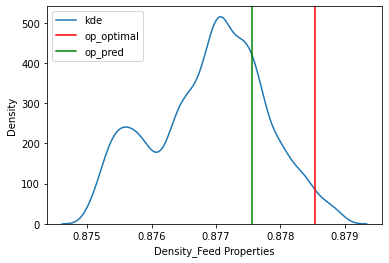

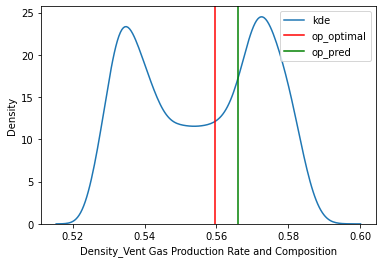

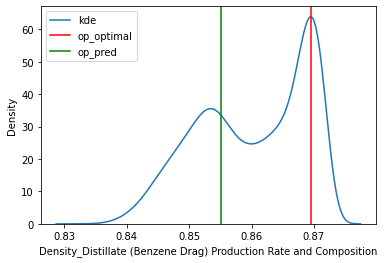

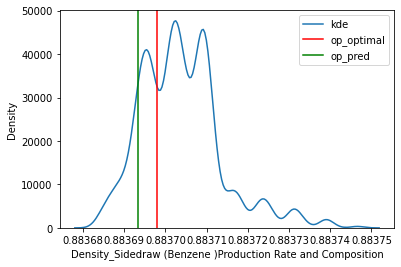

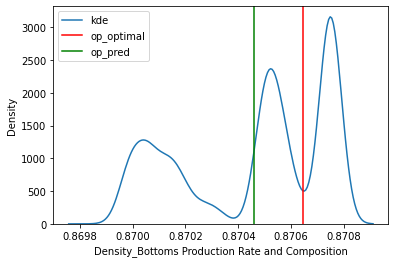

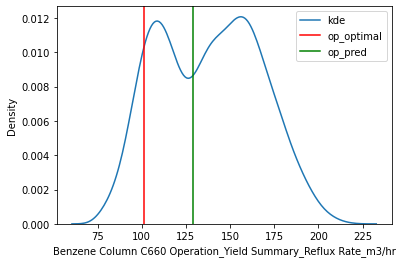

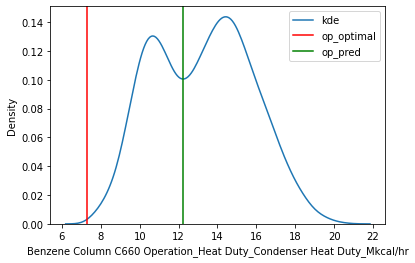

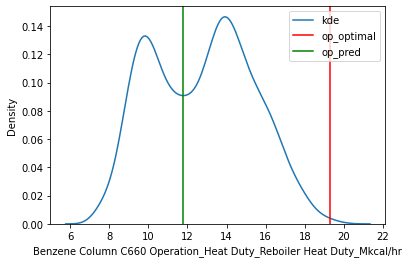

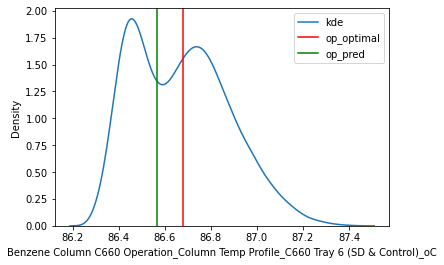

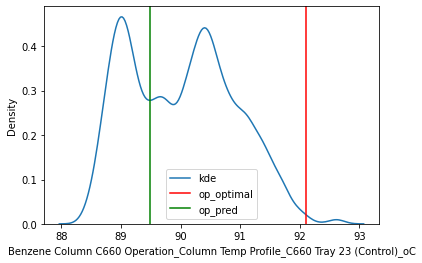

In [102]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [103]:
import joblib
G.shrink()
c660_f.shrink()
joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_G.pkl')
joblib.dump(c660_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl']